In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

print("OSMnx:", ox.__version__)  # 看一下版本

place = "Seoul, South Korea"
crs_plot = 3857

OSMnx: 2.0.6


In [2]:
# 1) 边界 + 路网
boundary = ox.geocoder.geocode_to_gdf(place).to_crs(crs_plot)
G = ox.graph_from_place(place, network_type="walk", simplify=True)
edges = ox.graph_to_gdfs(G, nodes=False).to_crs(crs_plot)

In [3]:
# 2) 便利店 POI（v2 用 features_from_place）
pois = ox.features_from_place(place, tags={"shop": "convenience"}).to_crs(crs_plot)

# 统一为点
pts = pois[pois.geometry.geom_type == "Point"].copy()
polys = pois[pois.geometry.geom_type.isin(["Polygon", "MultiPolygon"])].copy()
if len(polys):
    polys["geometry"] = polys.representative_point()
pois_pt = gpd.GeoDataFrame(pd.concat([pts, polys], ignore_index=True), crs=crs_plot)

# 只保留在城市边界内
pois_pt = gpd.sjoin(pois_pt, boundary[["geometry"]], predicate="within", how="inner").drop(columns=["index_right"])

# 品牌归一
def norm_brand(row):
    b = str(row.get("brand", "") or "").lower()
    n = str(row.get("name", "") or "").lower()
    if "gs25" in b or "gs25" in n: return "GS25"
    if "7-eleven" in b or "7 eleven" in b or "7-eleven" in n or "7 eleven" in n: return "7-Eleven"
    if b == "cu" or " cu" in b or n.startswith("cu") or " cu" in n: return "CU"
    return None

pois_pt["brand_norm"] = pois_pt.apply(norm_brand, axis=1)
brands = pois_pt[pois_pt["brand_norm"].isin(["GS25","CU","7-Eleven"])].copy()

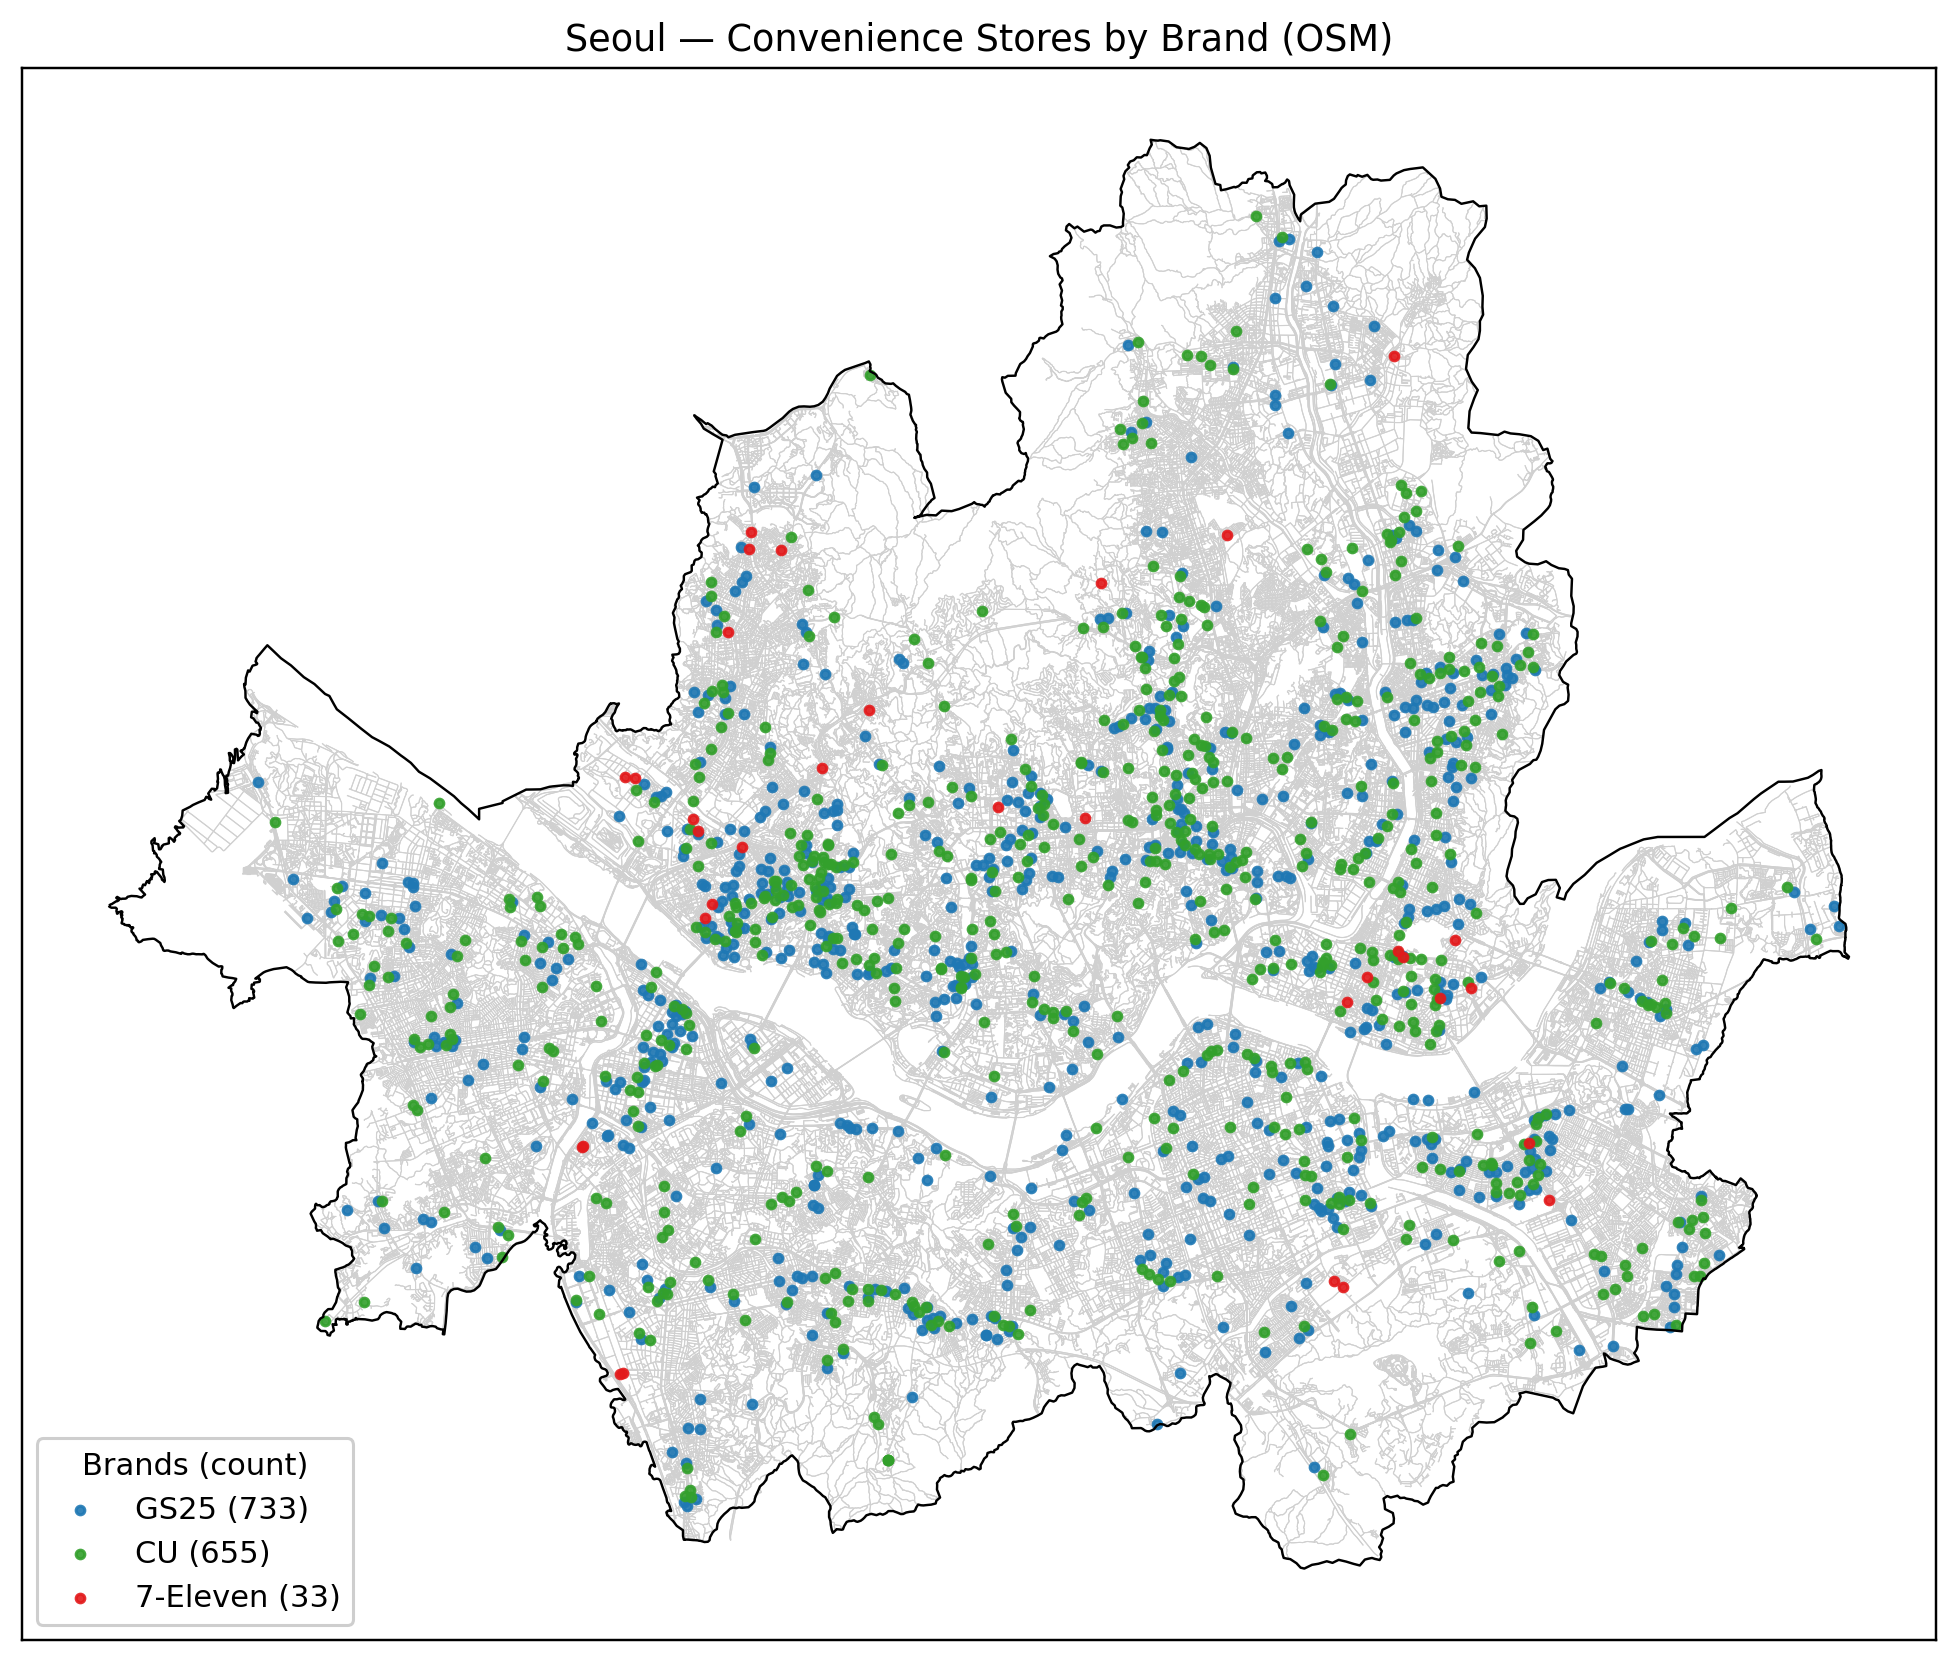

In [4]:
# 3) 作图
COL = {"GS25": (31/255,120/255,180/255), "CU": (51/255,160/255,44/255), "7-Eleven": (227/255,26/255,28/255)}
fig, ax = plt.subplots(figsize=(9,9), dpi=220)
edges.plot(ax=ax, color="#d0d0d0", linewidth=0.35, zorder=1)
boundary.boundary.plot(ax=ax, color="black", linewidth=0.8, zorder=4)
for b in ["GS25","CU","7-Eleven"]:
    sub = brands[brands["brand_norm"] == b]
    if len(sub): sub.plot(ax=ax, markersize=8, alpha=0.9, color=COL[b], label=f"{b} ({len(sub)})", zorder=3)
ax.set_aspect("equal"); ax.set_xticks([]); ax.set_yticks([])
ax.set_title("Seoul — Convenience Stores by Brand (OSM)", fontsize=12)
ax.legend(loc="lower left", frameon=True, framealpha=0.95, title="Brands (count)")
plt.tight_layout(); plt.show()

C:\Users\Jingqi\AppData\Local\Temp\ipykernel_29668\2015798185.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


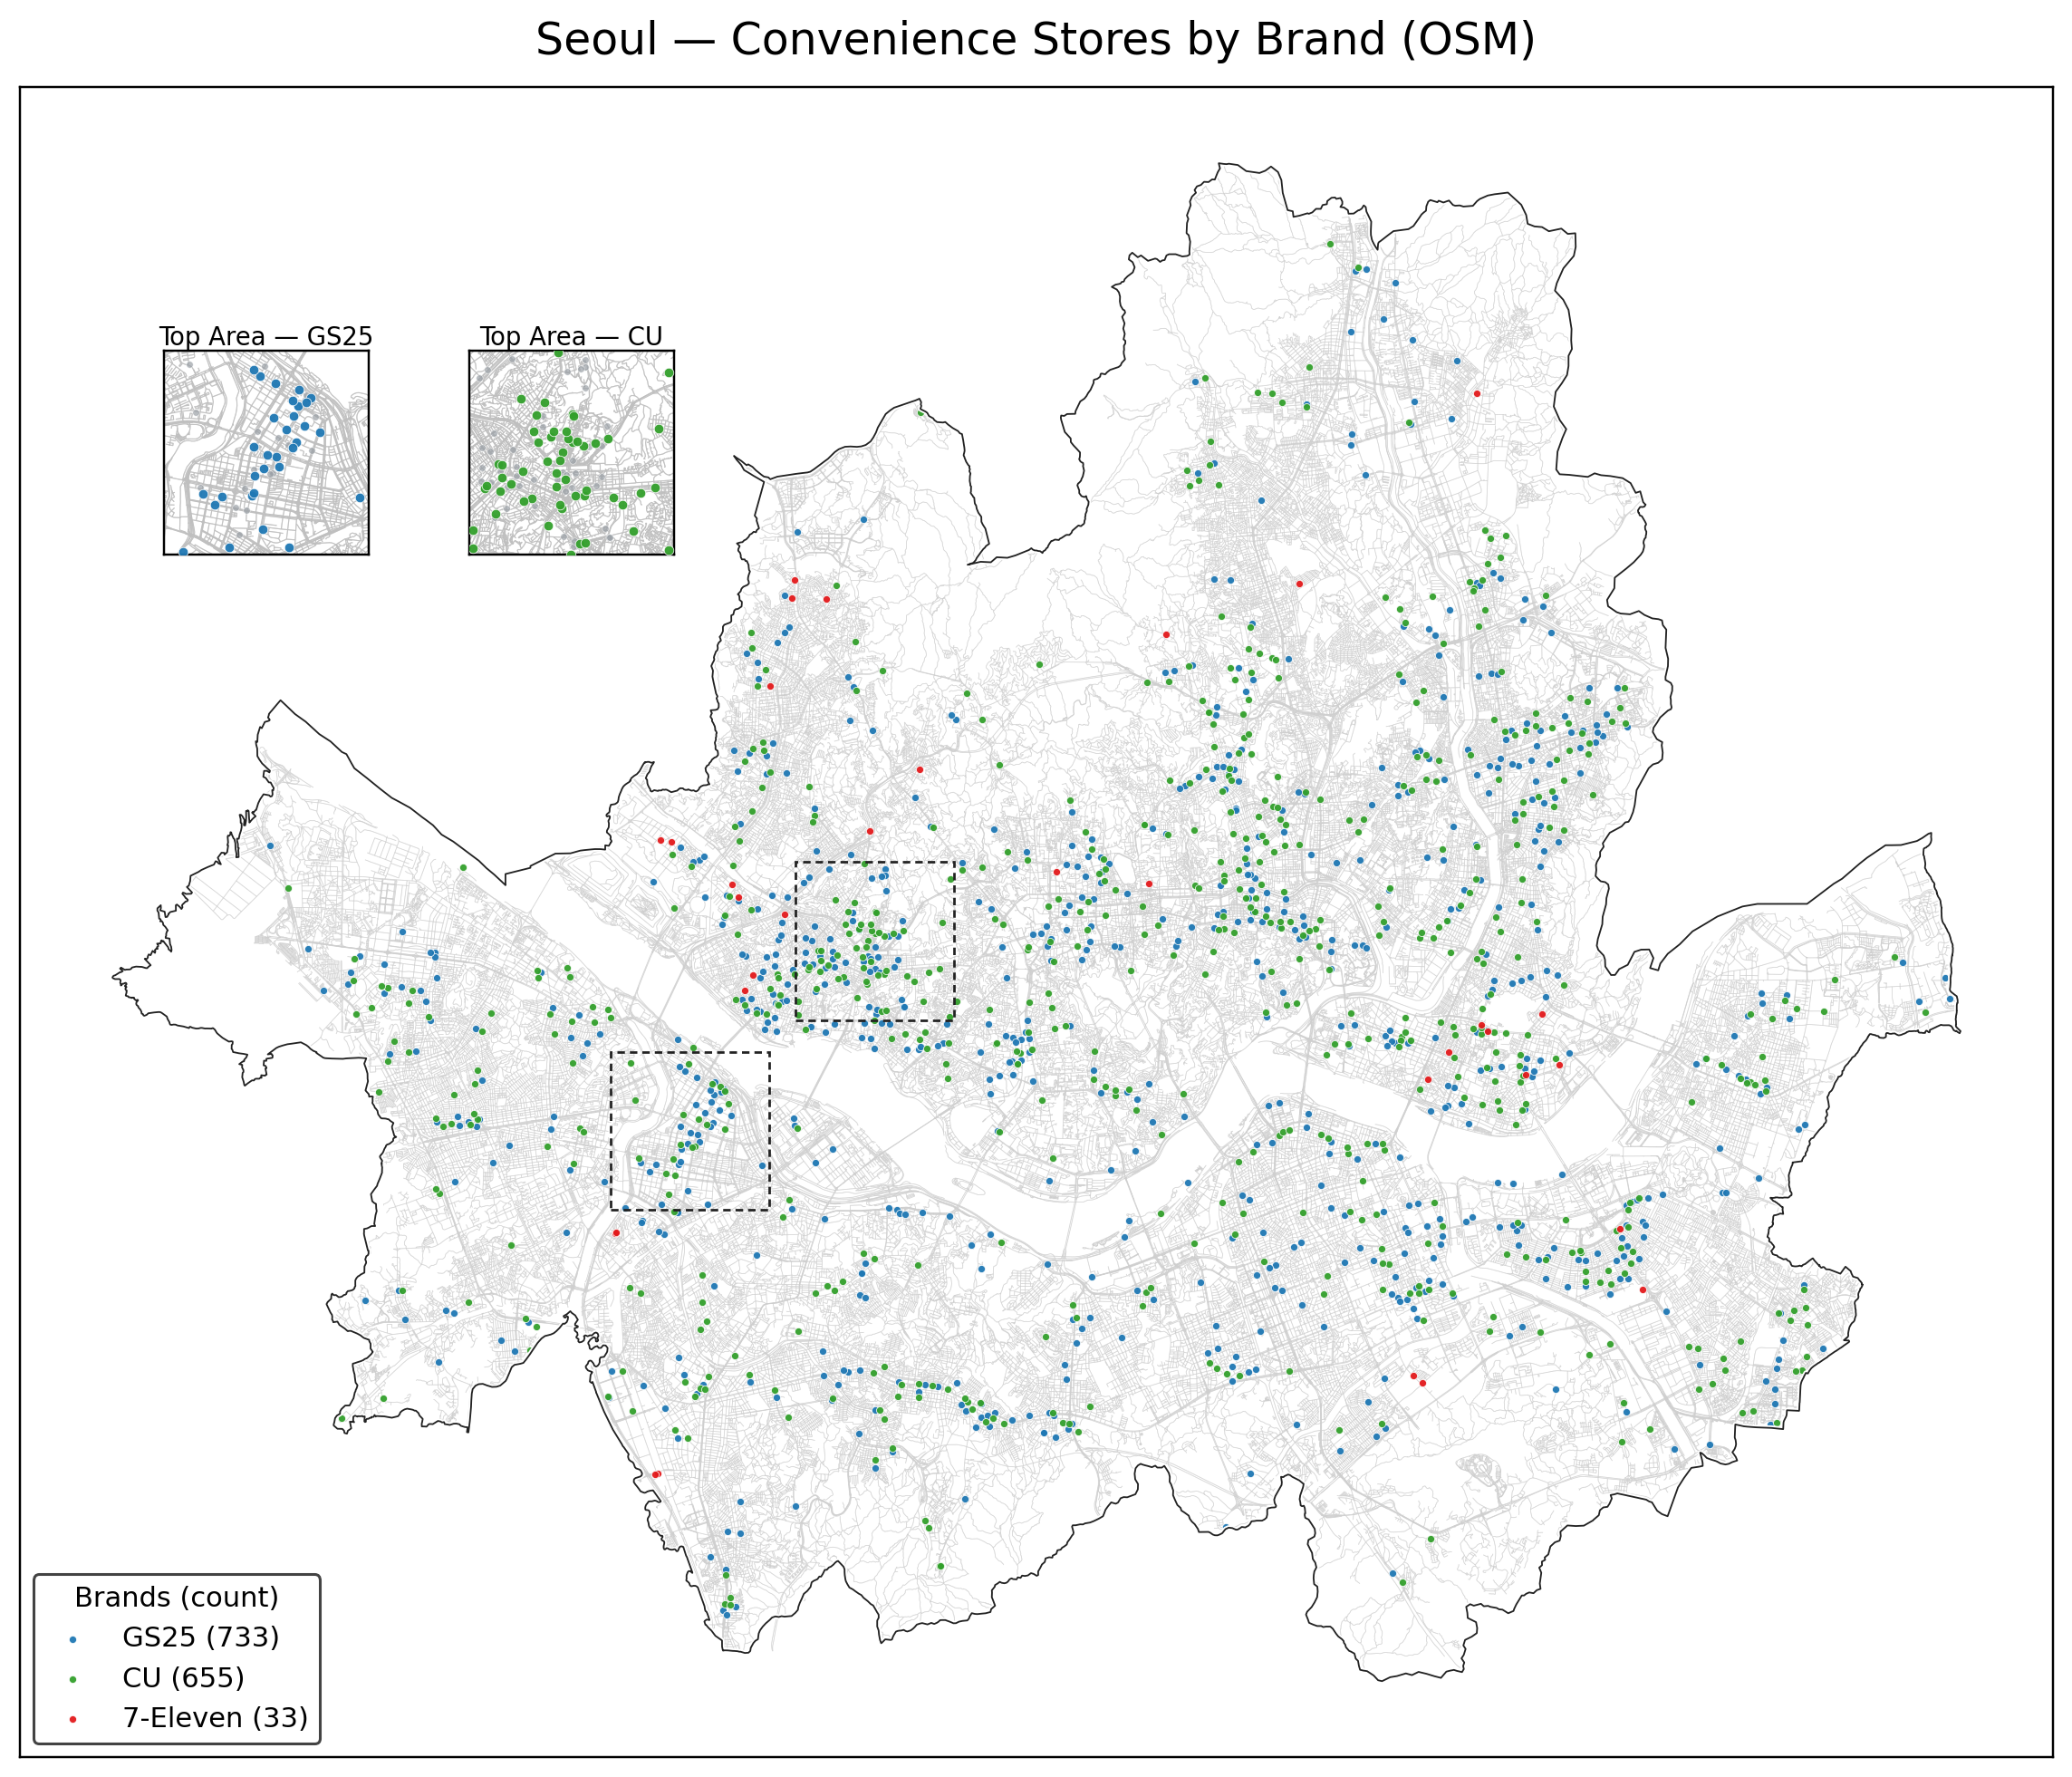

In [12]:
# ==== FIGURE CODE ONLY: main + two brand "Top area" insets ====
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
import numpy as np
import geopandas as gpd
from shapely.geometry import box

# --------- 1) 主图 ---------
fig, ax = plt.subplots(figsize=(10.5, 12), dpi=220)

# 底图：路网更淡、边界双描边
edges.plot(ax=ax, color="#cfcfcf", linewidth=0.25, alpha=0.6, zorder=1)
boundary.boundary.plot(ax=ax, color="white", linewidth=1.8, zorder=4)
boundary.boundary.plot(ax=ax, color="#222222", linewidth=0.6, zorder=5)

# 品牌点：白描边，稍小点
for b in ["GS25","CU","7-Eleven"]:
    sub = brands[brands["brand_norm"] == b]
    if len(sub):
        sub.plot(ax=ax, markersize=7, alpha=0.95, color=COL[b],
                 edgecolor="white", linewidth=0.25, label=f"{b} ({len(sub)})", zorder=3)

ax.set_aspect("equal", adjustable="box")
ax.set_xticks([]); ax.set_yticks([])
ax.set_title("Seoul — Convenience Stores by Brand (OSM)", fontsize=16, pad=12)

leg = ax.legend(loc="lower left", frameon=True, framealpha=0.92, title="Brands (count)")
leg.get_frame().set_facecolor("white")
leg.get_frame().set_edgecolor("#333")

# --------- 2) 选两大品牌 & 自动计算“Top 区域” bbox ----------
def brand_hotspot_bbox(gdf_brand, window_m=4000, bins=40):
    """在 3857 投影下，找该品牌密度最高的网格中心，并返回以此为中心的正方形 bbox（米）"""
    if len(gdf_brand) == 0:
        return None
    xs = gdf_brand.geometry.x.values
    ys = gdf_brand.geometry.y.values
    # 用城市边界范围建粗网格
    minx, miny, maxx, maxy = boundary.total_bounds
    H, xedges, yedges = np.histogram2d(xs, ys, bins=bins, range=[[minx, maxx], [miny, maxy]])
    ix, iy = np.unravel_index(H.argmax(), H.shape)  # 先 x 再 y
    cx = 0.5 * (xedges[ix] + xedges[ix+1])
    cy = 0.5 * (yedges[iy] + yedges[iy+1])

    half = window_m / 2.0
    return box(cx - half, cy - half, cx + half, cy + half)

# 选总数最多的两个品牌
brand_order = (brands["brand_norm"]
               .value_counts()
               .reindex(["GS25","CU","7-Eleven"])
               .dropna()
               .sort_values(ascending=False))
top2 = list(brand_order.index[:2])

bbox_dict = {}
for b in top2:
    bbox_dict[b] = brand_hotspot_bbox(brands[brands["brand_norm"] == b], window_m=4000)

# --------- 3) 小地图绘制函数 ----------
def plot_inset(ax_main, inset_anchor, inset_size, bbox_poly, focus_brand, title):
    """inset_anchor=(x0,y0) 是主轴坐标系里的左下角，inset_size=(w,h) 也是相对主轴的比例"""
    if bbox_poly is None:
        return
    # 放置 inset：确保在主图内（例如左下 0.06,0.06；右下 0.72,0.06）
    ax_in = inset_axes(ax_main,
                       width=f"{int(inset_size[0]*100)}%",
                       height=f"{int(inset_size[1]*100)}%",
                       bbox_to_anchor=(inset_anchor[0], inset_anchor[1], inset_size[0], inset_size[1]),
                       bbox_transform=ax_main.transAxes,
                       loc="lower left", borderpad=0)

    # 裁剪数据到 bbox
    edges_sub   = edges[edges.intersects(bbox_poly)]
    all_sub     = brands[brands.intersects(bbox_poly)]
    focus_sub   = all_sub[all_sub["brand_norm"] == focus_brand]
    other_sub   = all_sub[all_sub["brand_norm"] != focus_brand]

    # 背景与边界
    ax_in.set_facecolor("white")
    edges_sub.plot(ax=ax_in, color="#bfbfbf", linewidth=0.35, alpha=0.75, zorder=1)
    boundary.boundary.plot(ax=ax_in, color="#222", linewidth=0.4, zorder=3)

    # 其他品牌淡灰点
    if len(other_sub):
        other_sub.plot(ax=ax_in, markersize=6, color="#9aa0a6",
                       edgecolor="white", linewidth=0.2, alpha=0.7, zorder=2)

    # 重点品牌高亮
    if len(focus_sub):
        focus_sub.plot(ax=ax_in, markersize=12, color=COL[focus_brand],
                       edgecolor="white", linewidth=0.25, alpha=0.95, zorder=4)

    # 视窗范围
    minx, miny, maxx, maxy = bbox_poly.bounds
    ax_in.set_xlim(minx, maxx); ax_in.set_ylim(miny, maxy)
    ax_in.set_xticks([]); ax_in.set_yticks([])
    ax_in.set_title(title, fontsize=9, pad=2)

    # 在主图上画虚线框
    rect = mpatches.Rectangle((minx, miny), maxx-minx, maxy-miny,
                              fill=False, ec="#222", lw=0.9, ls=(0,(3,2)), zorder=10)
    ax_main.add_patch(rect)

# --------- 4) 放置两个“品牌 Top 区域” inset ----------
# 位置与大小（相对主轴）：避免出界
inset_w, inset_h = 0.35, 0.35
# 左上放第 1 名，右下放第 2 名（根据需要微调）
pos1 = (0.06, 0.72)
pos2 = (0.21, 0.72)

if len(top2) >= 1 and bbox_dict[top2[0]] is not None:
    plot_inset(ax, pos1, (inset_w, inset_h), bbox_dict[top2[0]], top2[0], f"Top Area — {top2[0]}")
if len(top2) >= 2 and bbox_dict[top2[1]] is not None:
    plot_inset(ax, pos2, (inset_w, inset_h), bbox_dict[top2[1]], top2[1], f"Top Area — {top2[1]}")

plt.tight_layout()
# plt.savefig("seoul_brand_insets_topareas.png", dpi=300, bbox_inches="tight")
# plt.show()
